In [14]:
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [15]:
jan = pd.read_csv('JAN_DATAFORPROJECT.csv')

In [16]:
jan.drop([ 'latitude', 'longitude', 'Georeference', 'Column1'], axis=1, inplace=True)

In [17]:
jan['transit_timestamp'] = pd.to_datetime(jan['transit_timestamp'])
jan['hour'] = jan['transit_timestamp'].dt.hour
jan['day_of_month'] = jan['transit_timestamp'].dt.day
jan['day_of_week'] = jan['transit_timestamp'].dt.dayofweek

In [18]:
jan.drop(columns='transit_timestamp', inplace=True)

In [19]:
jan['time_period'] = pd.cut(jan['hour'], 
                                bins=[-1, 5, 10, 15, 19, 23],
                                labels=['Early_Morning', 'Morning_Rush', 'Midday', 'Evening_Rush', 'Night'])

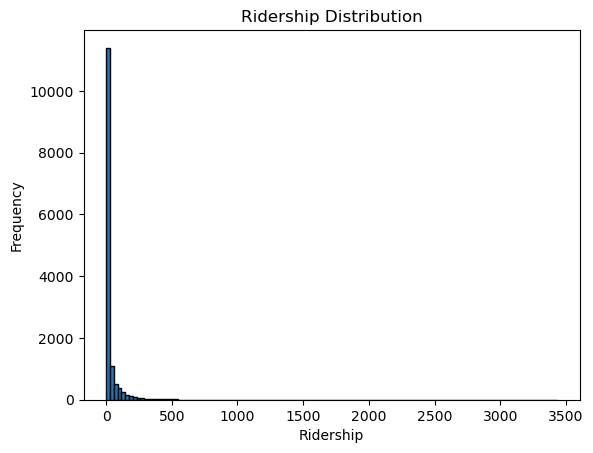

In [31]:
num_bins = int(np.sqrt(len(jan["ridership"])))

plt.hist(jan["ridership"], bins=num_bins, edgecolor="black")

plt.xlabel("Ridership")
plt.ylabel("Frequency")
plt.title("Ridership Distribution")

plt.show()

In [7]:
ridership_array = jan[['ridership']].values
kmeans = KMeans(n_clusters=2, random_state=6).fit(ridership_array)
jan['low_or_high'] = kmeans.labels_

In [8]:
low_ridership = jan[jan['low_or_high'] == 0]

In [9]:
low_ridership.drop(columns='low_or_high', inplace=True)

In [10]:
high_ridership = jan[jan['low_or_high'] == 1]

In [11]:
high_ridership.drop(columns='low_or_high', inplace=True)

In [12]:
#Other option for separating into low and high
#low_ridership = jan[jan['ridership'] < 25]
#high_ridership = jan[jan['ridership'] > 25]

### Low Ridership Model

In [13]:
low_ridership

,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,hour,day_of_month,day_of_week,time_period
0,tram,TRAM2,RI Tramway (Roosevelt),Manhattan,omny,OMNY - Full Fare,12,7,0,3,4,Early_Morning
1,tram,TRAM1,RI Tramway (Manhattan),Manhattan,omny,OMNY - Seniors & Disability,1,1,6,3,4,Morning_Rush
2,tram,TRAM2,RI Tramway (Roosevelt),Manhattan,metrocard,Metrocard - Unlimited 30-Day,10,0,7,3,4,Morning_Rush
3,tram,TRAM1,RI Tramway (Manhattan),Manhattan,metrocard,Metrocard - Unlimited 30-Day,5,0,8,3,4,Morning_Rush
4,tram,TRAM1,RI Tramway (Manhattan),Manhattan,omny,OMNY - Students,1,0,10,3,4,Morning_Rush
...,...,...,...,...,...,...,...,...,...,...,...,...
14313,subway,71,8 Av (N),Brooklyn,omny,OMNY - Full Fare,43,1,21,5,6,Night
14314,subway,83,"Woodhaven Blvd (J,Z)",Queens,omny,OMNY - Students,3,0,7,5,6,Morning_Rush
14315,subway,395,103 St (6),Manhattan,metrocard,Metrocard - Other,4,0,9,5,6,Morning_Rush
14316,subway,67,20 Av (D),Brooklyn,omny,OMNY - Full Fare,72,1,10,5,6,Morning_Rush


In [14]:
categorical_columns = ['transit_mode', 'station_complex_id', 'station_complex', 
                      'borough', 'payment_method', 'fare_class_category', 'time_period']
low_ridership_encoded = pd.get_dummies(low_ridership, columns=categorical_columns)
low_ridership_encoded = low_ridership_encoded.astype(int)

In [15]:
X = low_ridership_encoded.drop(['ridership'], axis=1)
y = low_ridership_encoded['ridership']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
low_ridership_encoded['transfers'] = scaler.fit_transform(low_ridership_encoded[['transfers']])

In [18]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,          
    min_samples_split=2,   
    min_samples_leaf=6,    
    max_features=0.65,
    random_state=402,
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [19]:
print("Performance Metrics:")
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Absolute Percent Error:", mean_absolute_percentage_error(y_test, y_pred))

Performance Metrics:
R² Score: 0.7612636128521272
Mean Absolute Error: 8.986045790714089
Root Mean Squared Error: 22.561405838805985
Mean Absolute Percent Error: 0.755640300464171


In [20]:
def regressionSummary(y_true, y_pred):
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"Mean Prediction: {np.mean(y_pred):.4f}")
    print(f"Actual Mean: {np.mean(y_true):.4f}")
    
    # Calculate percentage of predictions within different error ranges
    errors = np.abs(y_true - y_pred)
    print("\nPrediction Accuracy Ranges:")
    print(f"Within 10 riders: {100 * np.mean(errors <= 10):.2f}%")
    print(f"Within 25 riders: {100 * np.mean(errors <= 25):.2f}%")
    print(f"Within 50 riders: {100 * np.mean(errors <= 50):.2f}%")

# Get predictions for training set
y_train_pred = rf_model.predict(X_train)

print("Training Set Performance:")
regressionSummary(y_train, y_train_pred)

print("\nTest Set Performance:")
regressionSummary(y_test, y_pred)

Training Set Performance:
R² Score: 0.8450
Mean Absolute Error: 7.4129
Root Mean Squared Error: 18.1894
Mean Prediction: 23.9566
Actual Mean: 23.9040

Prediction Accuracy Ranges:
Within 10 riders: 82.57%
Within 25 riders: 92.92%
Within 50 riders: 97.11%

Test Set Performance:
R² Score: 0.7613
Mean Absolute Error: 8.9860
Root Mean Squared Error: 22.5614
Mean Prediction: 24.0372
Actual Mean: 23.9891

Prediction Accuracy Ranges:
Within 10 riders: 79.46%
Within 25 riders: 91.35%
Within 50 riders: 96.26%


### High Ridership Model

In [83]:
high_ridership.head()

,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,hour,day_of_month,day_of_week,time_period
109,tram,TRAM1,RI Tramway (Manhattan),Manhattan,omny,OMNY - Full Fare,414,200,16,3,4,Evening_Rush
399,tram,TRAM1,RI Tramway (Manhattan),Manhattan,omny,OMNY - Full Fare,452,167,16,1,2,Evening_Rush
418,tram,TRAM2,RI Tramway (Roosevelt),Manhattan,omny,OMNY - Full Fare,369,166,17,1,2,Evening_Rush
541,tram,TRAM1,RI Tramway (Manhattan),Manhattan,omny,OMNY - Full Fare,382,149,15,1,2,Midday
1048,tram,TRAM1,RI Tramway (Manhattan),Manhattan,omny,OMNY - Full Fare,375,186,16,4,5,Evening_Rush


In [84]:
categorical_columns = ['transit_mode', 'station_complex_id', 'station_complex', 
                      'borough', 'payment_method', 'fare_class_category', 'time_period']
high_ridership_encoded = pd.get_dummies(high_ridership, columns=categorical_columns)
high_ridership_encoded = high_ridership_encoded.astype(int)

In [85]:
X = high_ridership_encoded.drop(['ridership'], axis=1)
y = high_ridership_encoded['ridership']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
scaler = StandardScaler()
high_ridership_encoded['transfers'] = scaler.fit_transform(high_ridership_encoded[['transfers']])

In [88]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,          
    min_samples_split=6,       
    max_features=0.7,
    random_state=6,
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [89]:
print("Performance Metrics:")
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Absolute Percent Error:", mean_absolute_percentage_error(y_test, y_pred))

Performance Metrics:
R² Score: 0.3454941926816235
Mean Absolute Error: 214.87191303451593
Root Mean Squared Error: 277.4861800367314
Mean Absolute Percent Error: 0.299223981801042


In [90]:
def regressionSummary(y_true, y_pred):
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"Mean Prediction: {np.mean(y_pred):.4f}")
    print(f"Actual Mean: {np.mean(y_true):.4f}")
    
    # Calculate percentage of predictions within different error ranges
    errors = np.abs(y_true - y_pred)
    print("\nPrediction Accuracy Ranges:")
    print(f"Within 10 riders: {100 * np.mean(errors <= 10):.2f}%")
    print(f"Within 25 riders: {100 * np.mean(errors <= 25):.2f}%")
    print(f"Within 50 riders: {100 * np.mean(errors <= 50):.2f}%")

# Get predictions for training set
y_train_pred = rf_model.predict(X_train)

print("Training Set Performance:")
regressionSummary(y_train, y_train_pred)

print("\nTest Set Performance:")
regressionSummary(y_test, y_pred)

Training Set Performance:
R² Score: 0.7257
Mean Absolute Error: 146.8883
Root Mean Squared Error: 267.6793
Mean Prediction: 712.9541
Actual Mean: 719.3361

Prediction Accuracy Ranges:
Within 10 riders: 7.56%
Within 25 riders: 17.65%
Within 50 riders: 36.97%

Test Set Performance:
R² Score: 0.3455
Mean Absolute Error: 214.8719
Root Mean Squared Error: 277.4862
Mean Prediction: 652.0479
Actual Mean: 689.2333

Prediction Accuracy Ranges:
Within 10 riders: 0.00%
Within 25 riders: 6.67%
Within 50 riders: 10.00%


### Visuals

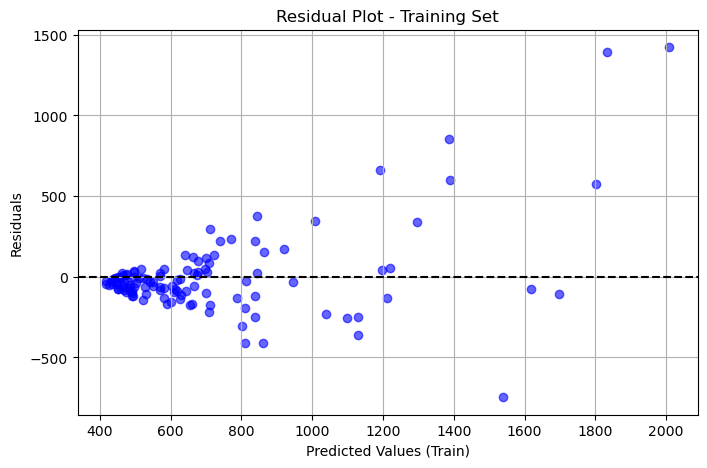

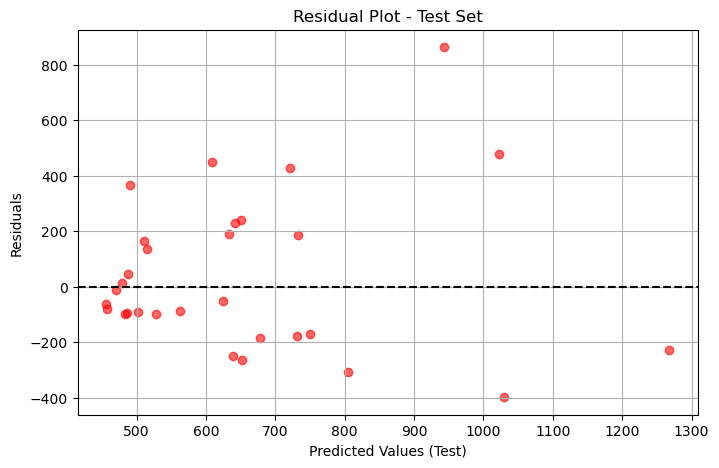

In [91]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_pred

# Plot 1: Training Residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_train_pred, train_residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values (Train)')
plt.ylabel('Residuals')
plt.title('Residual Plot - Training Set')
plt.grid(True)
plt.show()

# Plot 2: Test Residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, test_residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values (Test)')
plt.ylabel('Residuals')
plt.title('Residual Plot - Test Set')
plt.grid(True)
#plt.savefig('why.png')
plt.show()

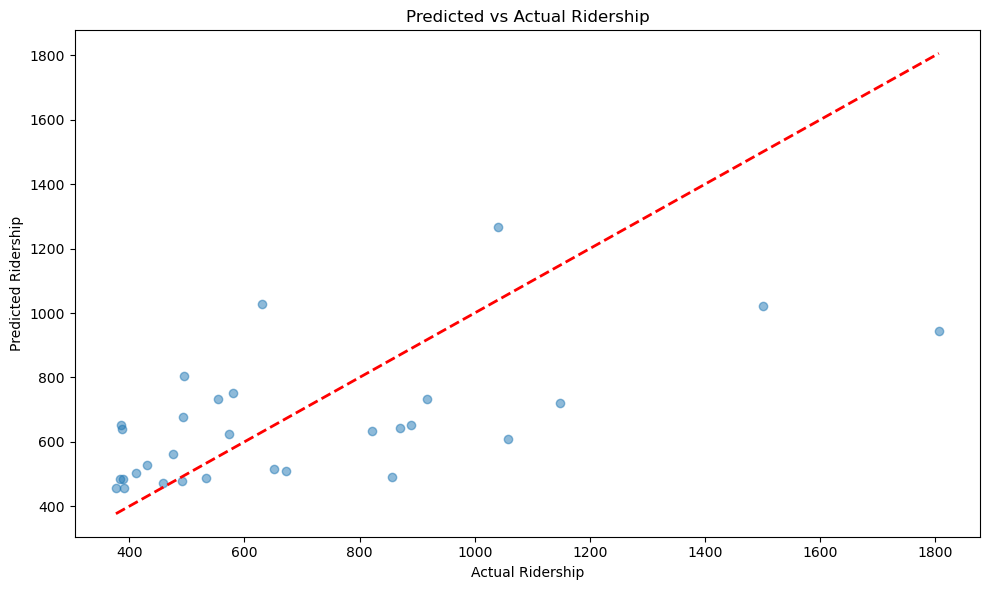

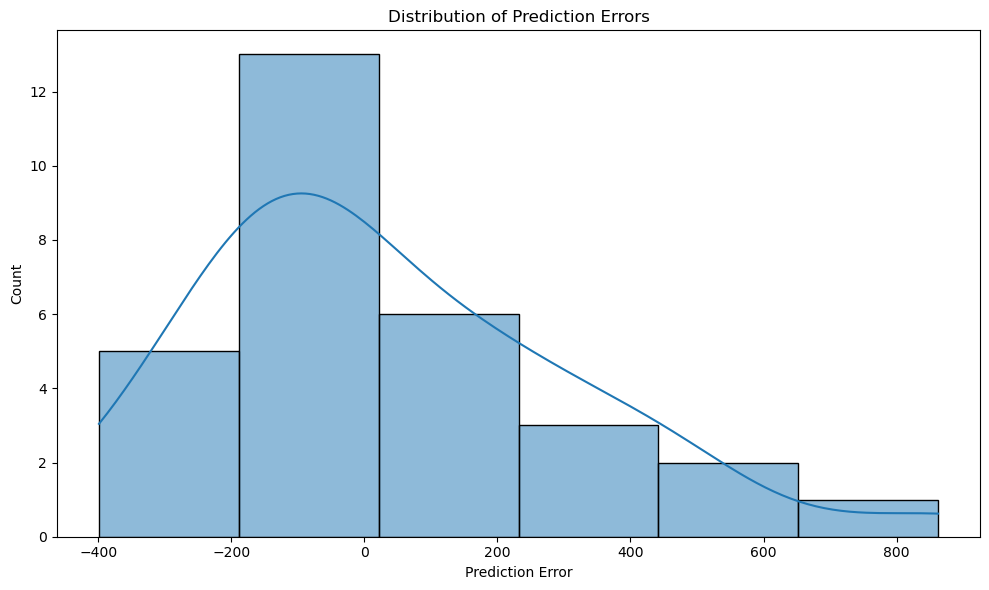

In [92]:
# Cell 11: Prediction Analysis
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Predicted vs Actual Ridership')
plt.tight_layout()
plt.show()

# Error Analysis
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

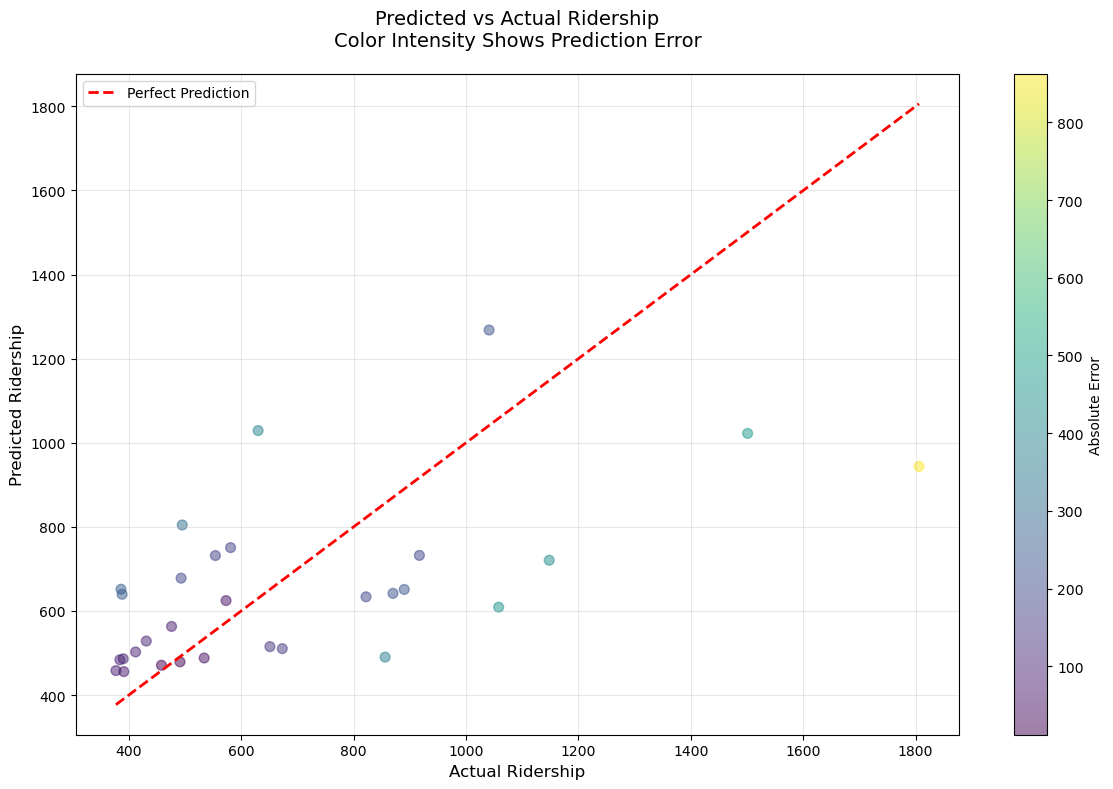

In [93]:
               # Cell 11: Enhanced Prediction Analysis
plt.figure(figsize=(12, 8))

# Create scatter plot with transparency and different colors based on error
errors = np.abs(y_test - y_pred)
scatter = plt.scatter(y_test, y_pred, 
                     alpha=0.5,  # Transparency
                      c=errors,   # Color based on error magnitude
                     cmap='viridis',  # Color map
                     s=50)      # Point size

# Add the perfect prediction line
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', 
         lw=2, 
         label='Perfect Prediction')

# Add colorbar to show error magnitude
plt.colorbar(scatter, label='Absolute Error')

# Add labels and title
plt.xlabel('Actual Ridership', fontsize=12)
plt.ylabel('Predicted Ridership', fontsize=12)
plt.title('Predicted vs Actual Ridership\nColor Intensity Shows Prediction Error', 
          fontsize=14, 
          pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()